# <b><u> Project Title : Extraction/identification of major topics & themes discussed in news articles. </u></b>

## <b> Problem Description </b>

### In this project your task is to identify major themes/topics across a collection of BBC news articles. You can use clustering algorithms such as Latent Dirichlet Allocation (LDA), Latent Semantic Analysis (LSA) etc.

## <b> Data Description </b>

### The dataset contains a set of news articles for each major segment consisting of business, entertainment, politics, sports and technology. You need to create an aggregate dataset of all the news articles and perform topic modeling on this dataset. Verify whether these topics correspond to the different tags available.

In [ ]:
#importing required libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import os
import re
import nltk
from nltk.tokenize import RegexpTokenizer

import warnings
warnings.filterwarnings("ignore")

from nltk.corpus import stopwords
nltk.download('stopwords')
import spacy
import gensim
from wordcloud import WordCloud
import nltk 
nltk.download('wordnet')
from nltk.tokenize import word_tokenize

import nltk 
nltk.download('punkt')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
!pip install pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 12.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=6de027ce918116b1d916b7cb9ab23586d23fa6698c9d95ed8fc13a762069fd7c
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=81ea9da231bad023a8b6839b0121e9c828a16fd1cdfc8c27383f7369afd44d87
  Stored in directory: /root/.cache/pip/wheels/42/56/cc/4a8bf86613aafd5b7f1b310477667c1fca5c51c3ae4124a003
Successfully built pyLDAvis sklearn


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


###Loading dataset

In [ ]:
#mouting drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#loading the data
News=[]
Type=[]

path="/content/drive/MyDrive/bbc"
folders=["business","entertainment","politics","sport","tech"] 
for i in folders:
    files=os.listdir(path+'/'+i)
    for text_file in files:
        file_path=path + '/'+i+'/'+text_file
        with open(file_path,'rb') as f:
            data=f.read()
        News.append(data)
        Type.append(i)
      

In [ ]:
#wrinting data to csv format
data={'news':News,'type':Type}
df = pd.DataFrame(data)
df.to_csv('./bbc.csv')

In [ ]:
df= pd.read_csv('bbc.csv')

###Data overview

In [ ]:
df.head()

,Unnamed: 0,news,type
0,0,"b""Peugeot deal boosts Mitsubishi\n\nStruggling...",business
1,1,b'Call centre users \'lose patience\'\n\nCusto...,business
2,2,b'China keeps tight rein on credit\n\nChina\'s...,business
3,3,b'US trade gap hits record in 2004\n\nThe gap ...,business
4,4,b'India\'s rupee hits five-year high\n\nIndia\...,business


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  2225 non-null   int64 
 1   news        2225 non-null   object
 2   type        2225 non-null   object
dtypes: int64(1), object(2)
memory usage: 52.3+ KB


In [ ]:
#Shape of dataframe
df.shape

(2225, 3)

In [ ]:
#descriprtion of object data type
df.describe(include='object')

,news,type
count,2225,2225
unique,2127,5
top,b'MPs issued with Blackberry threat\n\nMPs wil...,sport
freq,2,511


In [ ]:
#removing duplicates 
print(len(df[df['news'].duplicated()]))
df=df.drop_duplicates('news')

98


In [ ]:
#new shape of data frame
df.shape

(2127, 3)

In [ ]:
#dropping the index column of the dataset
df.drop('Unnamed: 0',axis=1,inplace=True)

In [ ]:
#different type of articles
print(df.type.unique())

['business' 'entertainment' 'politics' 'sport' 'tech']


In [ ]:
df.head()

,news,type
0,"b""Peugeot deal boosts Mitsubishi\n\nStruggling...",business
1,b'Call centre users \'lose patience\'\n\nCusto...,business
2,b'China keeps tight rein on credit\n\nChina\'s...,business
3,b'US trade gap hits record in 2004\n\nThe gap ...,business
4,b'India\'s rupee hits five-year high\n\nIndia\...,business


* The dataset consist of 2225 rows and 3 columns (unique_id,news,type)
* The news articles are of 5 unique types.
* The dataset has no null values but it has 98 duplicate news articles.
* The new shape of the dataset is 2127 rows with 3 columns after removal of duplicates

###Feature engineering

In [ ]:
#length of the news
df['length']=df.news.str.len()

In [ ]:
#function to count the number of words in the article
def word_count(article):
  return len(article.split(" "))

In [ ]:
# Getting word count of each article
df['word_count']=df['news'].apply(word_count)

In [ ]:
#Description of these new variable
df.describe()

,length,word_count
count,2127.000000,2127.000000
mean,2288.550071,379.444758
std,1393.870309,238.261401
min,512.000000,87.000000
25%,1460.000000,242.000000
50%,1987.000000,327.000000
75%,2825.500000,465.000000
max,25670.000000,4377.000000


In [ ]:
#Total number of words present in the whole corpus
Total_words=sum(df['word_count'])
Total_words

807079

In [ ]:
# Percentage of Types of news in the dataset
df['type'].value_counts(normalize=True)*100

sport            23.742360
business         23.648331
politics         18.946874
entertainment    17.348378
tech             16.314057
Name: type, dtype: float64

[Text(0.5, 1.0, 'Count of different types of news articles')]

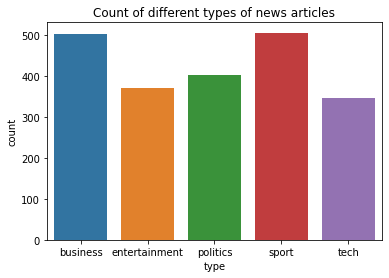

In [ ]:
#Countplot of different types of Articles in the dataset
sns.countplot(df['type']).set(title='Count of different types of news articles')

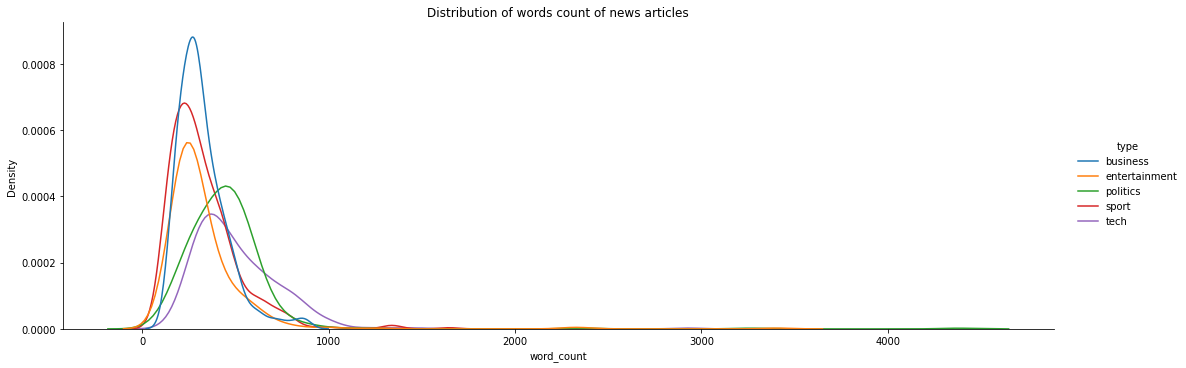

In [ ]:
#distribution of word counts of different news type
sns.displot(df, x="word_count", hue="type", kind="kde",height=5,aspect =3 ).set(title='Distribution of words count of news articles')

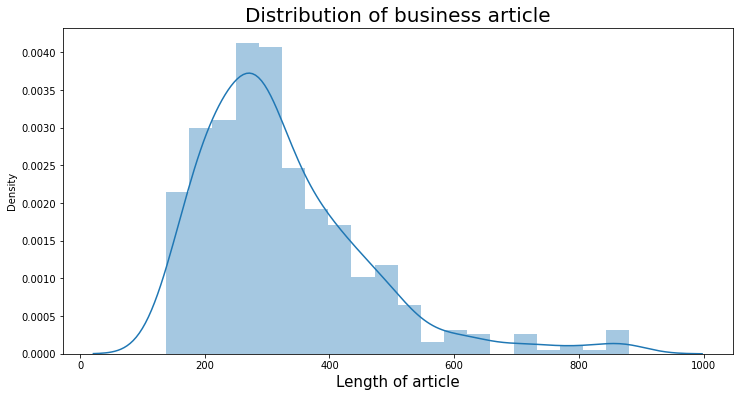

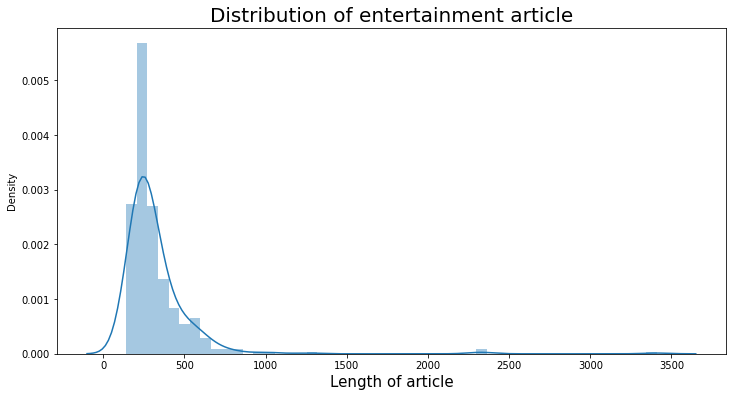

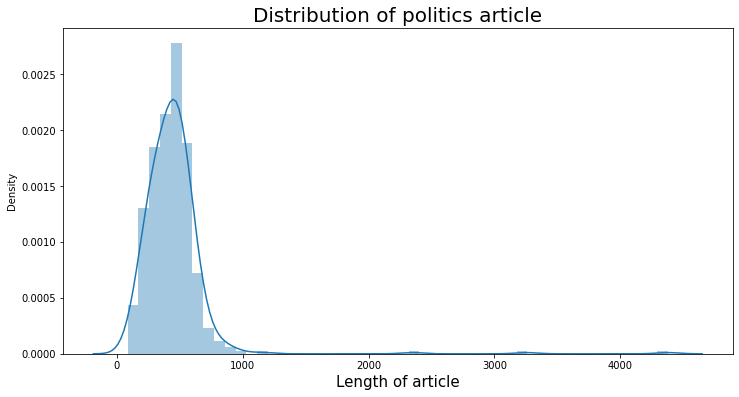

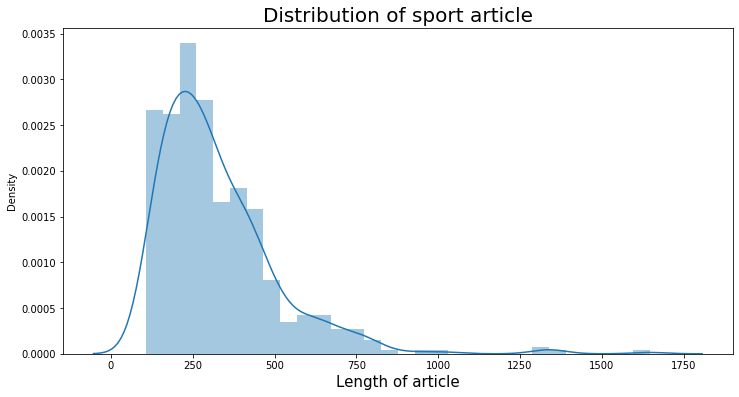

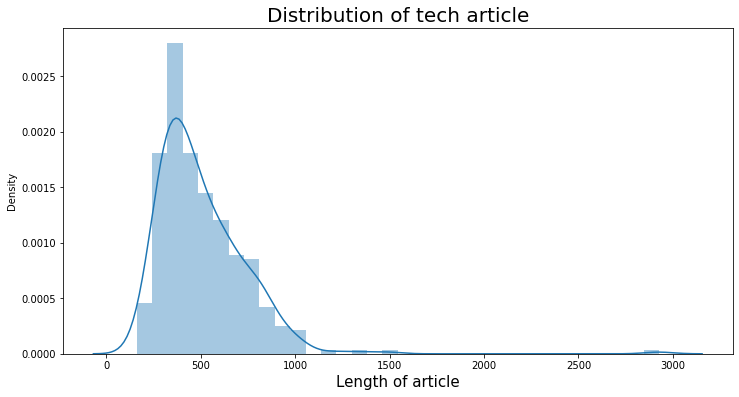

In [ ]:
#Distribution of different types of articles
types_article=list(df['type'].unique())
for article in types_article:
  df_article=df[df['type']==article]
  plt.figure(figsize=(12,6))
  fig=sns.distplot(x=df_article['word_count'])
  fig.set_title(f'Distribution of {article} article',size=20)
  fig.set_xlabel('Length of article',size=15)

* Topics Business and Sports have more number of news articles in the dataset.
* Business has more aritlces of lesser word-counts.
* Politics and Entertainment articles are bigger than any other topic.
* The curve shows most of the articles are of length 500 words approx.


###Data preprocessing

In [ ]:
#copying the original data
corpus_df=df.copy(deep=True)

In [ ]:
#First observation
obs=df['news'][0]
obs

'b"Peugeot deal boosts Mitsubishi\\n\\nStruggling Japanese car maker Mitsubishi Motors has struck a deal to supply French car maker Peugeot with 30,000 sports utility vehicles (SUV).\\n\\nThe two firms signed a Memorandum of Understanding, and say they expect to seal a final agreement by Spring 2005. The alliance comes as a badly-needed boost for loss-making Mitsubishi, after several profit warnings and poor sales. The SUVs will be built in Japan using Peugeot\'s diesel engines and sold mainly in the European market. Falling sales have left Mitsubishi Motors with underused capacity, and the production deal with Peugeot gives it a chance to utilise some of it.\\n\\nIn January, Mitsubishi Motors issued its third profits warning in nine months, and cut its sales forecasts for the year to March 2005. Its sales have slid 41% in the past year, catalysed by the revelation that the company had systematically been hiding records of faults and then secretly repairing vehicles. As a result, the J

* The above article has <b>punctuation, numericals , special characters and new line character </b>.  These are needed to be cleaned for further processing

In [ ]:
#Data preprocessing on a random observation
#Removal of newline character
obs=obs.replace('\\n'," ")

#Removal of all the punctuations,special character, numbers 
obs=re.sub("[^a-zA-Z]"," ",obs)

#conversion to lower case
obs=obs.lower()

#removal of additional whitespace
obs=re.sub(r'\s+'," ",obs)

#After basic cleaning
obs


'b peugeot deal boosts mitsubishi struggling japanese car maker mitsubishi motors has struck a deal to supply french car maker peugeot with sports utility vehicles suv the two firms signed a memorandum of understanding and say they expect to seal a final agreement by spring the alliance comes as a badly needed boost for loss making mitsubishi after several profit warnings and poor sales the suvs will be built in japan using peugeot s diesel engines and sold mainly in the european market falling sales have left mitsubishi motors with underused capacity and the production deal with peugeot gives it a chance to utilise some of it in january mitsubishi motors issued its third profits warning in nine months and cut its sales forecasts for the year to march its sales have slid in the past year catalysed by the revelation that the company had systematically been hiding records of faults and then secretly repairing vehicles as a result the japanese car maker has sought a series of financial ba

A basic cleaning has been performed . Now Applying this one whole data

In [ ]:
#Function to perform cleaning or preprocessing of articles
def cleaning(text):
  cleaned_text = text.replace('\\n'," ")                              # removal of new line symbol \n 
  
  cleaned_text = re.sub("[^a-zA-Z]"," ",cleaned_text)                 # removal of all the punctuations,special character, numbers
  
  cleaned_text = cleaned_text.lower()                                 # converting to lower case 
  
  cleaned_text = re.sub(r'\s+'," ",cleaned_text)                      # Removal of additional white space
  
  return cleaned_text

In [ ]:
#Applying basic cleaning to whole data
corpus_df['news']=corpus_df['news'].apply(cleaning)

In [ ]:
#Word Count after basic cleaning
corpus_df['wc_after_cleaning']=corpus_df['news'].apply(word_count)

In [ ]:
corpus_df.head()

,news,type,length,word_count,wc_after_cleaning
0,b peugeot deal boosts mitsubishi struggling ja...,business,1846,296,301
1,b call centre users lose patience customers tr...,business,3882,653,643
2,b china keeps tight rein on credit china s eff...,business,1404,245,241
3,b us trade gap hits record in the gap between ...,business,1984,324,326
4,b india s rupee hits five year high india s ru...,business,1023,172,183


####Lemmatization

In [ ]:
#Lemmatization 
import nltk 
nltk.download('punkt')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
def lemmatize_word(text):
    word_list = word_tokenize(text)
    lemma = WordNetLemmatizer()
    word_list = [lemma.lemmatize(word) for word in word_list]
    # list to sentence
    return ' '.join(word_list)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
#Applying lemmatization
corpus_df['news']=corpus_df['news'].apply(lemmatize_word)

[Text(0.5, 1.0, 'Top 20 most frequent words in the corpus')]

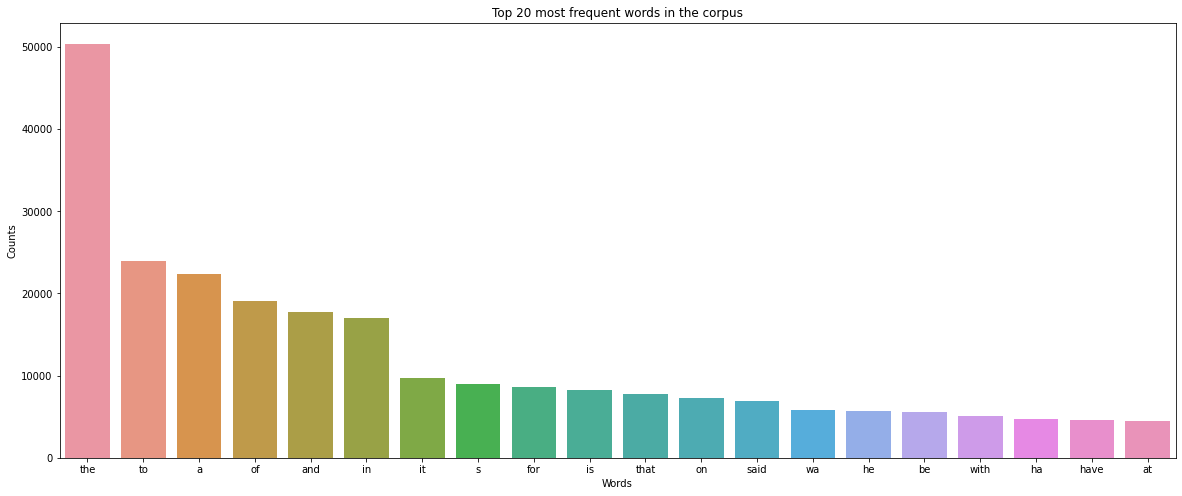

In [ ]:
#Top 20 most frequent words in the corpus
Top_20_freq = pd.Series(' '.join(corpus_df['news']).split()).value_counts()[:20]
top20=pd.DataFrame()
top20['Words']= list(Top_20_freq.index)
top20['Counts']=list(Top_20_freq.values)

fig, ax = plt.subplots(figsize=(20,8))
sns.barplot(x = 'Words',y = 'Counts',data = top20,ax=ax).set(title='Top 20 most frequent words in the corpus')

* The graph shows that stopwords are most frequent in the whole dataset. So these stopwords need to be removed.
*Also the short length (< 3) words are most frequent.

In [ ]:
#Removing short length words ( length less than 3)
def short_length(text):
  return (' '.join([wds for wds in text.split() if len(wds)>2]))

corpus_df['news']=corpus_df['news'].apply(short_length)


In [ ]:
#Word count after removal of short length
corpus_df['wc_rem_short_len']=corpus_df['news'].apply(word_count)

In [ ]:
corpus_df.head()

,news,type,length,word_count,wc_after_cleaning,wc_rem_short_len
0,peugeot deal boost mitsubishi struggling japan...,business,1846,296,301,228
1,call centre user lose patience customer trying...,business,3882,653,643,516
2,china keep tight rein credit china effort stop...,business,1404,245,241,180
3,trade gap hit record the gap between export an...,business,1984,324,326,241
4,india rupee hit five year high india rupee hit...,business,1023,172,183,130


####Removing Stopwords

In [ ]:
#Stopwords
# list of stopwords from nltk
stopwords_nltk = list(stopwords.words('english'))

# list of stopwords from spacy
sp = spacy.load('en_core_web_sm')
stopwords_spacy = list(sp.Defaults.stop_words)

# list of stopwords from gensim
stopwords_gensim = list(gensim.parsing.preprocessing.STOPWORDS)

# unique stopwords from all stopwords
all_stopwords = []
all_stopwords.extend(stopwords_nltk)
all_stopwords.extend(stopwords_spacy)
all_stopwords.extend(stopwords_gensim)

# all unique stop words
all_stopwords = list(set(all_stopwords))

def stop_words(text):
  text = [wd.lower() for wd in text.split() if wd.lower() not in all_stopwords]
  return " ".join(text)

In [ ]:
len(all_stopwords)

413

In [ ]:
#Removal of Stopwords
corpus_df['news']=corpus_df['news'].apply(stop_words)

In [ ]:
# word count after removing the stopwords
corpus_df['after_stop']=corpus_df['news'].apply(word_count)

In [ ]:
corpus_df.head()

,news,type,length,word_count,wc_after_cleaning,wc_rem_short_len,after_stop
0,peugeot deal boost mitsubishi struggling japan...,business,1846,296,301,228,163
1,centre user lose patience customer trying cent...,business,3882,653,643,516,288
2,china tight rein credit china effort stop econ...,business,1404,245,241,180,119
3,trade gap hit record gap export import hit tim...,business,1984,324,326,241,157
4,india rupee hit year high india rupee hit year...,business,1023,172,183,130,84


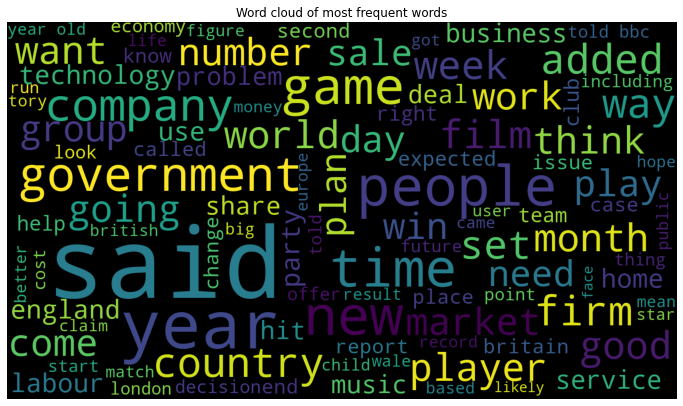

In [ ]:
# Cloud Words plot for displaying most frequent words in the data 
freq_words = ','.join(list(corpus_df['news'].values))

wordcloud = WordCloud(width=1366, height=768, random_state=21,max_words=100 ,max_font_size=200,background_color='black').generate(freq_words)
plt.figure(figsize=(12, 7))
plt.imshow(wordcloud)
plt.title('Word cloud of most frequent words')
plt.axis('off')
plt.show()

In [ ]:
#removal of non-contextual words
add_stopwords= ['said','told','called','use','know','came','based','way','added','including','got']

In [ ]:
#Function to remove additional stopwords 
def remove_add_stopwords(text):
  text = [wd.lower() for wd in text.split() if wd.lower() not in add_stopwords]
  return " ".join(text)


In [ ]:
#Removing addtional stopwords according to use case
corpus_df['news']=corpus_df['news'].apply(remove_add_stopwords)

In [ ]:
# word count after removing the additional stopwords
corpus_df['wc_rem_stopword']=corpus_df['news'].apply(word_count)

In [ ]:
corpus_df.head()

,news,type,length,word_count,wc_after_cleaning,wc_rem_short_len,after_stop,wc_rem_stopword
0,peugeot deal boost mitsubishi struggling japan...,business,1846,296,301,228,163,162
1,centre user lose patience customer trying cent...,business,3882,653,643,516,288,285
2,china tight rein credit china effort stop econ...,business,1404,245,241,180,119,119
3,trade gap hit record gap export import hit tim...,business,1984,324,326,241,157,155
4,india rupee hit year high india rupee hit year...,business,1023,172,183,130,84,82


[Text(0.5, 1.0, 'Top 20 most frequent words in the corpus After stopword removal')]

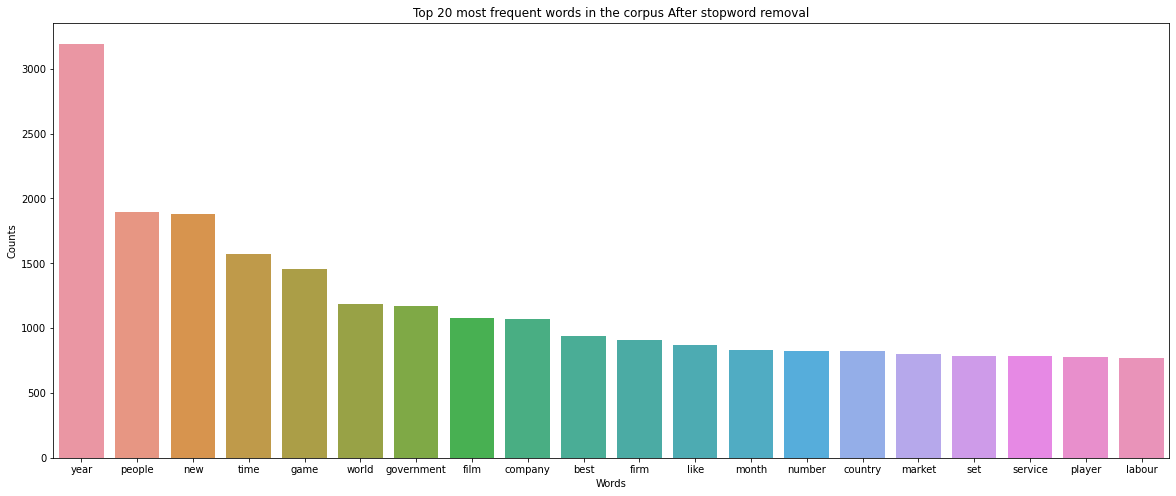

In [ ]:
#Top 20 most frequent words in the corpus After stopword removal
Top_20_freq = pd.Series(' '.join(corpus_df['news']).split()).value_counts()[:20]
top20=pd.DataFrame()
top20['Words']= list(Top_20_freq.index)
top20['Counts']=list(Top_20_freq.values)

fig, ax = plt.subplots(figsize=(20,8))
sns.barplot(x = 'Words',y = 'Counts',data = top20,ax=ax).set(title='Top 20 most frequent words in the corpus After stopword removal')

* After removing stopwords, the frequencies of contexual words are more apparent. 

#### Visualization of top 20 bi-gram & tri-gram 

In [ ]:
def get_top_n_gram(corpus, ngram, n=20):

    ''' 
    This functions takes entire corpus and returns list of tuple in  pair words and number of its occurence.
    '''
    # creates instance of count vectorizer for n-grams
    vec = CountVectorizer(ngram_range=(ngram,ngram)).fit(corpus)

    # returns sparse matrix of index as documents and columns as Bow as features
    bag_of_words = vec.transform(corpus)

    # returns 2D array with count of features in corpus
    sum_words = bag_of_words.sum(axis=0) 

    # returns list of tuples with text,counts pair
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

    # sort the list of tuples by its number of occurence
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

    # returns list of tuples top n words
    return words_freq[:n]

[Text(0.5, 1.0, 'Top 20 bigram words')]

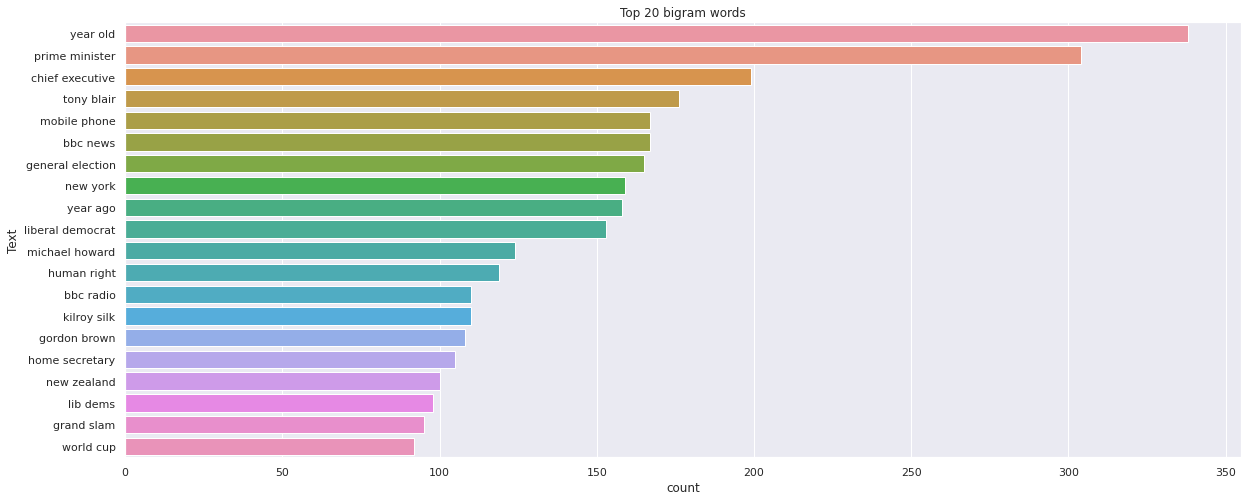

In [ ]:
# get top 20 bigram words using function
common_words = get_top_n_gram(corpus_df['news'],ngram=2)

# creates dataframe from list of tuples 
df1 = pd.DataFrame(common_words, columns = ['Text' , 'count'])

# plot top 20 words
sns.set(font_scale = 1)

fig, ax = plt.subplots(figsize=(20,8))
sns.barplot(y= 'Text',x = 'count',data = df1,ax=ax).set(title='Top 20 bigram words')

[Text(0.5, 1.0, 'Top 20 trigram words')]

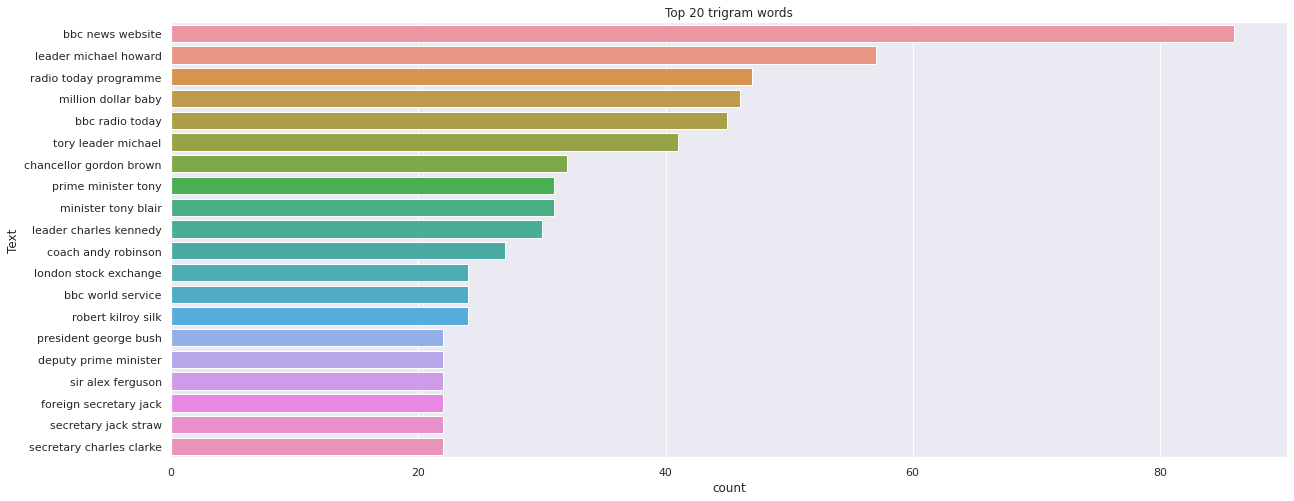

In [ ]:
# get top 20 trigram words using function
common_words = get_top_n_gram(corpus_df['news'],ngram=3)

# creates dataframe from list of tuples 
df2 = pd.DataFrame(common_words, columns = ['Text' , 'count'])

# plot top 20 words
sns.set(font_scale = 1)

fig, ax = plt.subplots(figsize=(20,8))
sns.barplot(y= 'Text',x = 'count',data = df2,ax=ax).set(title='Top 20 trigram words')

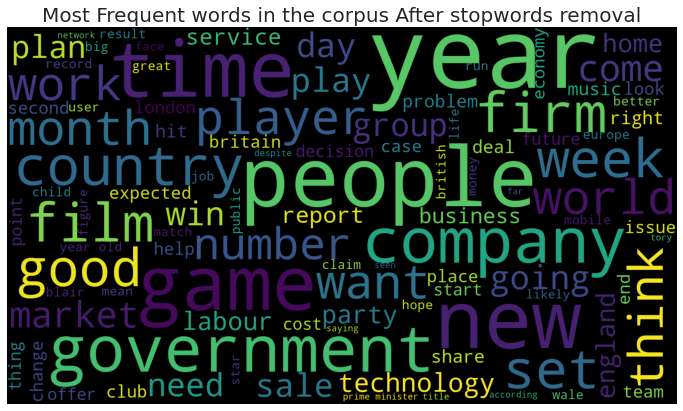

In [ ]:
#Most Frequent words in the corpus
freq_words = ','.join(list(corpus_df['news'].values))

wordcloud = WordCloud(width=1366, height=768, random_state=42,max_words=100 ,max_font_size=200,background_color='black').generate(freq_words)
plt.figure(figsize=(12, 7))
plt.imshow(wordcloud)
plt.title('Most Frequent words in the corpus After stopwords removal',size=20)
plt.axis('off')
plt.show()

In [ ]:
#Data reduction 
after_preprocess=corpus_df['wc_rem_stopword'].sum()
after_preprocess

data_reduce=(after_preprocess/Total_words)*100
data_reduce

48.56823185834349

* Almost 50% of unneccessary data has been removed.

####LDA

In [ ]:
#Tf-Idf vectoriser
vectorizer = TfidfVectorizer(min_df = 0.03)
document_term_matrix = vectorizer.fit_transform(corpus_df['news'])

In [ ]:
#Shape of document term matrix
document_term_matrix.shape

(2127, 947)

In [ ]:

# Parameters tuning using Grid Search
from sklearn.model_selection import GridSearchCV
grid_params = {'n_components' : list(range(5,10))}

# LDA model
lda_model = GridSearchCV(LatentDirichletAllocation(),param_grid=grid_params)
lda_model.fit(document_term_matrix)

# Best LDA model
best_lda_model = lda_model.best_estimator_

print("Best LDA model's params" , lda_model.best_params_)
print("Best log likelihood Score for the LDA model",lda_model.best_score_)
print("LDA model Perplexity on train data", best_lda_model.perplexity(document_term_matrix))

Best LDA model's params {'n_components': 5}
Best log likelihood Score for the LDA model -24294.99054125761
LDA model Perplexity on train data 1446.9579758868433


In [ ]:
# LDA model fitting for best parameter
lda= LatentDirichletAllocation(n_components=5,max_iter=1000,random_state=42, n_jobs=-1)
lda.fit(document_term_matrix)

LatentDirichletAllocation(max_iter=1000, n_components=5, n_jobs=-1,
                          random_state=42)

In [ ]:
# LDA model
top_lda=lda.fit_transform(document_term_matrix)

print(top_lda.shape)
print(top_lda)

(2127, 5)
[[0.02777719 0.88873094 0.0274679  0.0277795  0.02824448]
 [0.02737138 0.74745721 0.02634086 0.1710435  0.02778705]
 [0.02948842 0.8823183  0.0290104  0.02963842 0.02954446]
 ...
 [0.23362634 0.03110627 0.02993047 0.67361597 0.03172095]
 [0.02557599 0.4180475  0.02438306 0.50566167 0.02633178]
 [0.76169287 0.02967374 0.02841475 0.15076188 0.02945675]]


In [ ]:
# composition of doc 0 for eg
print("Document 0: ")
for i,topic in enumerate(top_lda[0]):
  print("Topic ",i,": ",topic*100,"%")

Document 0: 
Topic  0 :  2.7777193633441675 %
Topic  1 :  88.87309361304402 %
Topic  2 :  2.7467896305209147 %
Topic  3 :  2.777949565956113 %
Topic  4 :  2.824447827134789 %


* The first document is more belonging to the Topic 1.

In [ ]:
import pyLDAvis.sklearn
lda_panel = pyLDAvis.sklearn.prepare(best_lda_model, document_term_matrix,vectorizer,mds='tsne')
lda_panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
2      150.222153  -72.269554       1        1  46.739075
1       51.163364 -159.968018       2        1  22.557593
0      -73.144554   21.523815       3        1  13.722577
3      -66.410133 -110.606438       4        1  13.498334
4       54.417324   12.443444       5        1   3.482422, topic_info=         Term       Freq      Total Category  logprob  loglift
328      film  64.000000  64.000000  Default  30.0000  30.0000
67      award  37.000000  37.000000  Default  29.0000  29.0000
514      mail  21.000000  21.000000  Default  28.0000  28.0000
792      site  22.000000  22.000000  Default  27.0000  27.0000
761  security  21.000000  21.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
218      data   2.423766  17.690007   Topic5  -5.2607   1.3698
333      firm   3.952915  44.985262   Topic5  -4.7716   0.9256
619    people   2.334281  59.435206   Topic5  -5.2983   0.1203
327      file   1.651531  13.277775   Topic5  -5.6443   1.2731
625     phone   1.764606  29.321673   Topic5  -5.5781   0.5470

[249 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
2         1  0.373426   access
2         3  0.522796   access
9         4  0.940231    actor
10        4  0.938530  actress
30        4  0.930122    album
...     ...       ...      ...
939       4  0.103792    world
944       1  0.462134     year
944       2  0.248842     year
944       3  0.082947     year
944       4  0.201443     year

[495 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1, 4, 5])

####LSA

In [ ]:
# create svd instance
svd_model = TruncatedSVD(n_components=5,random_state=42,algorithm='randomized')

# fit model to data
svd_model.fit(document_term_matrix)

tsvd_mat=svd_model.transform(document_term_matrix)

In [ ]:
#Shape of truncated SVD
tsvd_mat.shape

(2127, 5)

In [ ]:
#Using t-sne for transformation
tsne = TSNE(n_components=2)
tsne_mat = tsne.fit_transform(tsvd_mat)

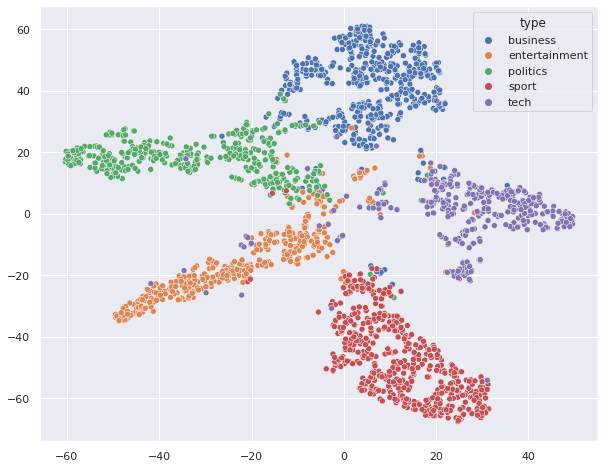

In [ ]:
#Scatter plot of the topics using the t-sne in LSA
plt.figure(figsize=(10,8))
sns.scatterplot(tsne_mat[:,0],tsne_mat[:,1],hue=corpus_df['type'])

* The points of technology  & business clusters are scattered at different areas.

###Conclusion

* There are 5 different topic present in the aricles.
* LDA and LSA are implemented to find the hidden topics.
* LDA performs well & shows 5 different clusters present in the Corpus.
* LSA also shows the 5 different clusters present in the scatterplot.
